보스턴 주택 가격 data set
보스턴 교외의 주택 평균 가격을 예측하려고 합니다
1970년대 중반, 범죄율, 지방 재산세율 등 사용할 데이터셋에는 흥미로운 차이점이 있습니다.
이전의 두 예에서 데이터 포인트가 상대적으로 적습니다. 506개만 분할됩니다.
404개의 교육용 샘플과 102개의 테스트 샘플 사이에 있습니다. 그리고 입력 데이터의 각 기능
(예를 들어, 범죄율)은 크기가 다릅니다. 예를 들어, 일부 값은 비율입니다.
0과 1 사이의 값을 갖는 것, 1과 12 사이의 값을 갖는 것
0~100사이 등등

boston_housing data를 20번 훈련시키자.

In [1]:
from keras.datasets import boston_housing

Using TensorFlow backend.


In [0]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

시험 데이터의 정규화에 사용되는 수량은
교육 자료 작업흐름에서 계산한 수량을 사용해서는 안 됩니다.
테스트 데이터, 심지어 데이터 정규화 같은 간단한 데이터도 마찬가지입니다.

In [0]:
mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std

test_data -= mean
test_data /= std

모든 것이 완전히 다른 신경 네트워크 값을 입력하는 것은 문제가 될 수 있다.
네트워크는 이러한 이기종 ( heterogeneous)에 자동으로 적응할 수 있습니다.
하지만 그것은 분명히 학습을 더 어렵게 만들 것이다. 광범위한 모범 사례
이러한 데이터를 처리하는 것은 기능별 정규화를 수행하는 것이다.
데이터(입력 데이터 행렬의 열), 형상의 평균을 뺀다.
표준 편차로 나누어서 형상이 0 주위에 중심에 있고
단위 표준 편차 이것은 Numpy에서 쉽게 할 수 있다.

In [0]:
from keras import models
from keras import layers

네트워크 구축
매우 적은 수의 샘플을 사용할 수 있으므로, 두 개의 숨겨진 네트워크가 있는 매우 작은 네트워크를 사용할 수 있습니다.
각 레이어는 64개 유닛으로 구성됩니다. 일반적으로 교육 데이터가 적을수록
작은 네트워크를 사용하는 것이 오버피팅을 완화하는 한 가지 방법입니다.

In [0]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation = 'relu',
                         input_shape = (train_data.shape[1],)))
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
  return model

네트워크는 단일 장치로 종료되고 활성화되지 않습니다(선형 레이어가 됨). 이것은
스칼라 회귀 분석을 위한 일반적인 설정(하나의 스칼라 회귀 분석)
지속적 가치 활성화 기능을 적용하면 출력 범위를 제한합니다.
예를 들어 마지막 계층에 Sigmoid 활성화 기능을 적용한 경우
네트워크는 0과 1 사이의 값만 예측할 수 있었습니다. 자, 마지막
계층은 순수하게 선형이고, 네트워크는 어떤 범위의 값들을 예측하는 것을 배우는데 자유롭다.
네트워크를 mse 손실 함수(평균 제곱 오류),
예측과 목표 사이의 차이 제곱 이것은 널리 퍼져있다.
회귀 문제에 사용되는 손실 함수입니다.
또한 교육 중에 새 메트릭스(평균 절대 오류(MAE)도 모니터링합니다. 그것은
예측과 목표 사이의 차이에 대한 절대값 위해서
예를 들어, 이 문제에 대해 MAE가 0.5이면 예측이 500달러까지 빗나가게 됩니다.
보통, 대개, 대략

In [0]:
import numpy as np

K-폴드 검증을 사용하여 접근 검증
매개변수(예: 숫자)를 조정하는 동안 네트워크를 평가하려면
교육에 사용된 시대), 데이터를 교육 세트 및 검증 세트로 분할할 수 있습니다.
이전 예에서와 같이 설정. 하지만 데이터 포인트가 너무 적어서
검증 집합은 결국 매우 작아집니다(예: 약 100개의 예).
그 결과, 검증 점수는 어떤 데이터에 따라 크게 달라질 수 있습니다.
유효성 검사에 사용하도록 선택한 점과 교육용으로 선택한 점: 유효성 검사
점수는 유효성 분할과 관련하여 높은 차이를 보일 수 있다. 이렇게 하면 방지할 수 있습니다.
당신은 당신의 모델을 신뢰성 있게 평가하지 않는다.
이러한 상황에서 가장 좋은 방법은 K-폴 교차 검증을 사용하는 것이다(그림 3.11 참조).
사용 가능한 데이터를 K 파티션(일반적으로 K = 4 또는 5)으로 분할하여 인스턴스화합니다.
K 동일 모델 및 K – 1개 파티션에서 각각 평가
나머지 칸막이 사용된 모델의 유효성 점수는
K 검증 점수 코드 측면에서 이것은 간단하다.

In [7]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
  print('처리중인 폴드 #', i)
  val_data = train_data[i*num_val_samples: (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
  
  partial_train_data = np.concatenate(
      [train_data[:i*num_val_samples],
       train_data[(i+1)*num_val_samples:]],
      axis = 0)
  partial_train_targets = np.concatenate(
      [train_targets[:i*num_val_samples],
       train_targets[(i+1)*num_val_samples:]],
      axis = 0)
  
  model = build_model()
  model.fit(partial_train_data, partial_train_targets, 
            epochs = num_epochs, batch_size = 1, verbose = 0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
  all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [8]:
num_epoch = 500
all_mae_histories = []
for i in range(k):
  print('처리중인 폴드 #', i)
  val_data = train_data[i*num_val_samples: (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
  
  partial_train_data = np.concatenate(
      [train_data[:i*num_val_samples],
       train_data[(i + 1) * num_val_samples:]], 
      axis = 0)
  
  partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]], axis = 0)
  
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data = (val_data, val_targets), epochs = num_epochs, batch_size = 1, verbose = 0)
  
  mae_history = history.history['val_mean_absolute_error']
  all_mae_histories.append(mae_history)
  
 

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [0]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

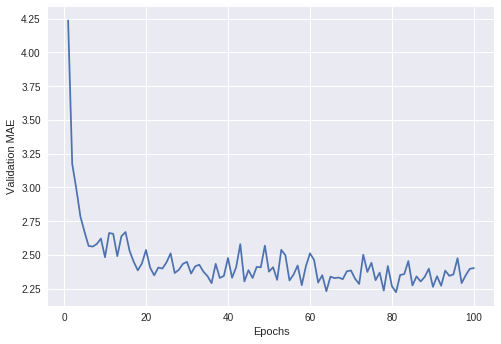

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

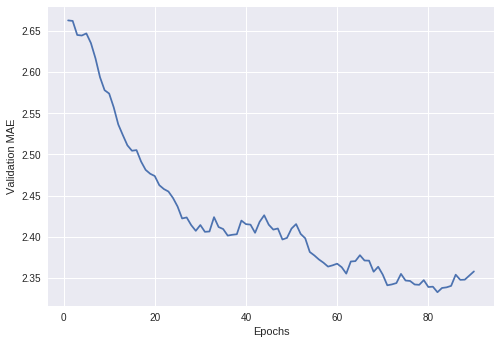

In [12]:
def smooth_curve(points, factor = 0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()
